In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from scipy.stats import norm

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

### Import Dataset

In [2]:
df = pd.read_csv('FraudDetectionDataset.csv')

df = df.drop(['nameOrig', 'nameDest'], axis=1)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
df.shape

(6362620, 9)

In [5]:
# Check for null values

df.isnull().sum() # yay no null values! 

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Data Visualizations

### Visualization of Class Imbalance

In fraud detection datasets, it is common to see extreme class imbalance, i.e. considerably more non-fraudulent observations than fraudulent observations. Let's take a look and see how the classes are distributed in this dataset. 

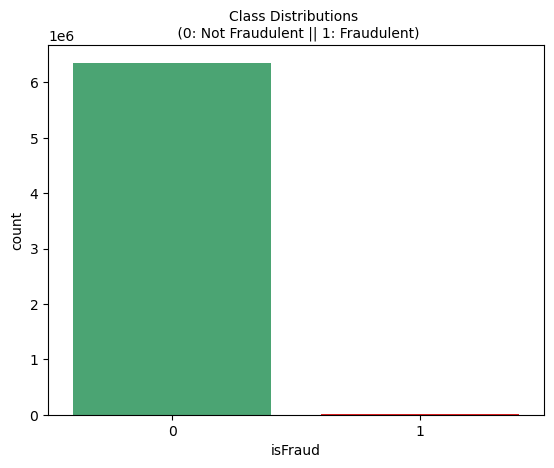

In [6]:
# There are so few fraudulent examples in comparison to non-fraudulent examples
# that we can barely see the fraudulent examples on the graph! 

colors = [ 'mediumseagreen', 'red'] 
sns.countplot(x=df['isFraud'], palette=colors);
plt.title('Class Distributions \n (0: Not Fraudulent || 1: Fraudulent)', fontsize=10);

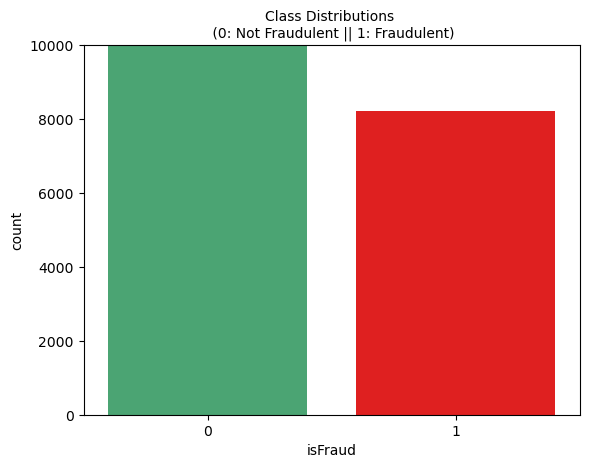

In [7]:
# Now that we have zoomed in quite a bit we can see that there are in fact 
# many fraudulent examples

sns.countplot(x=df['isFraud'], palette=colors);
plt.ylim([0,10000]);
plt.title('Class Distributions \n (0: Not Fraudulent || 1: Fraudulent)', fontsize=10);

In [8]:
print('Is not fraudulent:', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Is fraudulent:', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# We will fix class skewness later by performing random undersampling

Is not fraudulent: 99.87 % of the dataset
Is fraudulent: 0.13 % of the dataset


### Other Data Visualizations

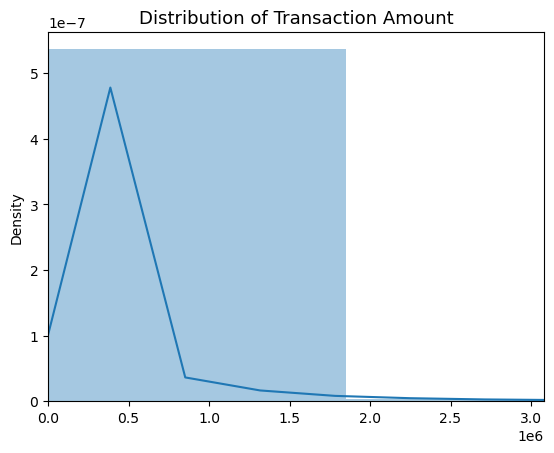

In [9]:
# Distributions of some of the features

amount_values = df['amount'].values

sns.distplot(amount_values);
plt.xlim([min(amount_values), max(amount_values)/30]);
plt.title('Distribution of Transaction Amount', fontsize=13);

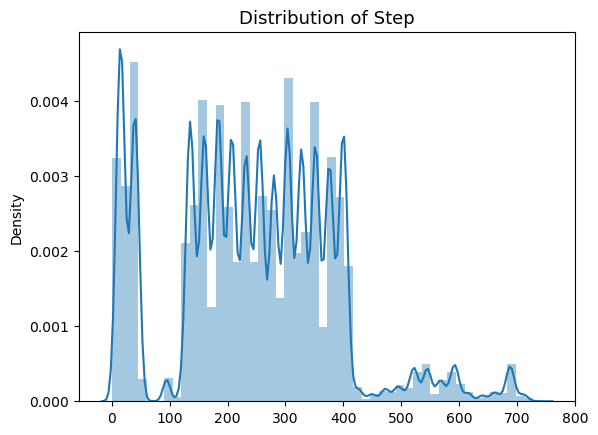

In [10]:
sns.distplot(df['step'].values);
plt.title('Distribution of Step', fontsize=13);

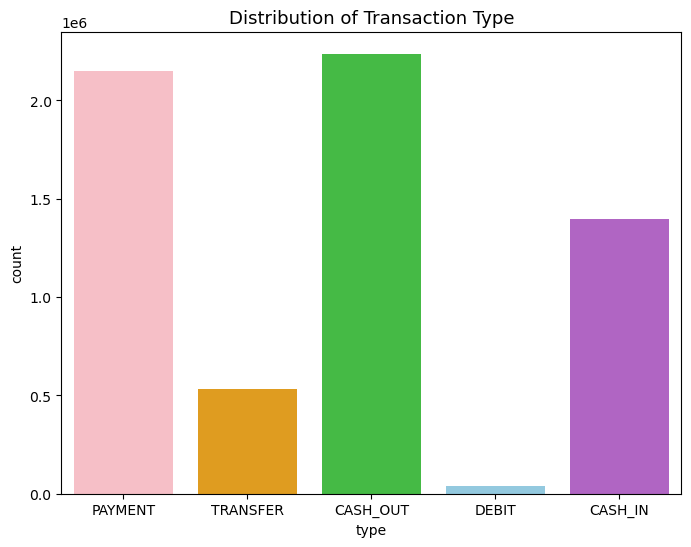

In [11]:
colors = ['lightpink','orange','limegreen','skyblue','mediumorchid']
plt.figure(figsize=(8,6));
sns.countplot(x=df['type'], palette=colors)
plt.title('Distribution of Transaction Type', fontsize=13);

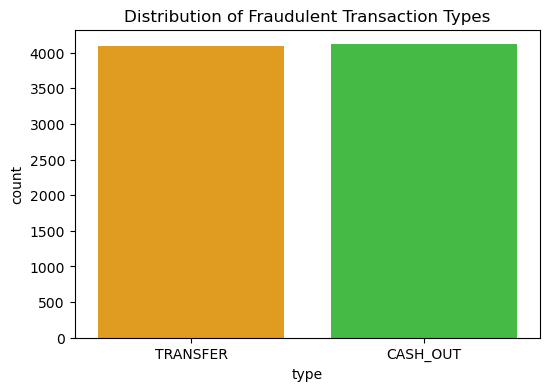

In [12]:
# It makes sense that the only types of transactions associated with fraudulent transactions 
# are transfers and cash out

data = df[(df['isFraud']==1)]['type']
plt.figure(figsize=(6,4))
sns.countplot(data, palette=['orange', 'limegreen']);
plt.title('Distribution of Fraudulent Transaction Types', fontsize=12);

# Data Preprocessing

In [13]:
# Separate numerical and categorical columns for scaling/encoding 

from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df)
categorical_columns = categorical_columns_selector(df)

### Encode Categorical Features

In [14]:
categorical_df = df[categorical_columns]
categorical_df.describe()

,type
count,6362620
unique,5
top,CASH_OUT
freq,2237500


In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
categorical_df = pd.DataFrame (encoder.fit_transform(categorical_df))

In [16]:
categorical_df.columns = encoder.get_feature_names(['TYPE'])
categorical_df.head()

,TYPE_CASH_IN,TYPE_CASH_OUT,TYPE_DEBIT,TYPE_PAYMENT,TYPE_TRANSFER
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0


### Scale Numerical Features

In [17]:
df[numerical_columns].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [18]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler();

In [19]:
# There is no need to scale binary variables, so we will leave 'isFraud' and 'isFlaggedFraud' out of the scaling process

numerical = numerical_columns[0:-2]
 
for i in numerical:
    df[f'SCALED_{i.upper()}'] = robust_scaler.fit_transform(df[i].values.reshape(-1,1))
    df.drop([i], axis=1, inplace=True)

In [20]:
# Reformat column indices so 'isFraud' and 'isFlaggedFraud' are at the end of the dataframe

temp_cols = df.columns.tolist()
index = df.columns.get_loc('isFraud')
new_cols = temp_cols[index+2:] + temp_cols[index:index+2]
df = df[new_cols]

In [21]:
df = pd.concat([categorical_df,df], axis = 1)
df.head()

,TYPE_CASH_IN,TYPE_CASH_OUT,TYPE_DEBIT,TYPE_PAYMENT,TYPE_TRANSFER,SCALED_STEP,SCALED_AMOUNT,SCALED_OLDBALANCEORG,SCALED_NEWBALANCEORIG,SCALED_OLDBALANCEDEST,SCALED_NEWBALANCEDEST,isFraud,isFlaggedFraud
0,0.0,0.0,0.0,1.0,0.0,-1.329609,-0.332932,1.452991,1.111175,-0.140722,-0.193057,0,0
1,0.0,0.0,0.0,1.0,0.0,-1.329609,-0.373762,0.065610,0.134375,-0.140722,-0.193057,0,0
2,0.0,0.0,0.0,0.0,1.0,-1.329609,-0.382380,-0.130708,0.000000,-0.140722,-0.193057,1,0
3,0.0,1.0,0.0,0.0,0.0,-1.329609,-0.382380,-0.130708,0.000000,-0.118260,-0.193057,1,0
4,0.0,0.0,0.0,1.0,0.0,-1.329609,-0.323571,0.254820,0.207169,-0.140722,-0.193057,0,0


# Handling Extreme Class Imbalance

### Creating A Balanced Sub-Sample Using Random Undersampling

In a previous section, we saw that fraudulent observations make up only 0.13% of the dataset. If class imbalance is not properly addressed in the training set, the model will develop a bias - assuming that most observations are not fraudulent - and it will not learn to correctly identify fraudulent transactions. To address this class imbalance, we will perform a technique called Random Undersampling. 

When implementing the Random Undersampling technique, we count the number of minority examples in the dataset and randomly select the same number of observations from the majority class. The implementation of the technique results in an evenly balanced sub-sample that we will use to train the classification models on.

In [22]:
# Randomly shuffle dataset
df = df.sample(frac=1)


# Create balanced sub-sample 
fraud_df = df.loc[df['isFraud'] == 1]
non_fraud_df = df.loc[df['isFraud'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])


# New balanced dataframe for model training
new_df = normal_distributed_df.sample(frac=1)

In [23]:
new_df.shape

(16426, 13)

In [24]:
print('Distribution of the Classes in the Sub-Sample Dataset:');
print(new_df['isFraud'].value_counts()/len(new_df));

Distribution of the Classes in the Sub-Sample Dataset:
0    0.5
1    0.5
Name: isFraud, dtype: float64


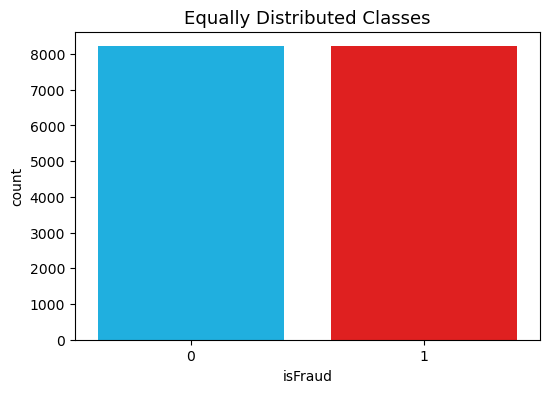

In [25]:
plt.figure(figsize=(6,4))
sns.countplot('isFraud', data=new_df, palette=['deepskyblue', 'red']);
plt.title('Equally Distributed Classes', fontsize=13);

# Splitting the Data into Training and Test Sets

In this section we will split the data into training and test sets. To train the classification models, we will use the sub-sample created in the previous section to prevent training bias. Then, we will use data from the original, unbalanced, dataset to test the classification model accuracy. 

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Shuffles and splits data into train and test sets while preserving the percentage of samples for each class
# We will increase the size of the testing set as a buffer against duplicates
sss = StratifiedShuffleSplit(n_splits=5, test_size = 0.2)

for i, (train_index, test_index) in enumerate(sss.split(X,y)):
    print(f'Fold {i}:') 
    print('Train:', train_index, 'Test:', test_index) 
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index] 
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Fold 0:
Train: [ 529594 4815754 1792272 ... 4550502 5758287 5942360] Test: [4243908 1334169 1102060 ... 4097829 2967711  531819]
Fold 1:
Train: [3765983 5373425 2756217 ... 3051973 3467613 1438986] Test: [5254639 2342028 3129856 ...  177573 3130282 3945149]
Fold 2:
Train: [5488904 6124501 1407029 ... 3351401 3793730 4133315] Test: [2521169 5889211 2229465 ... 5602919 1881364  558897]
Fold 3:
Train: [ 995773 4632528 5747693 ...  454936 6183763 1669923] Test: [5746734 1841562 5234811 ... 6355501 1920631 2916493]
Fold 4:
Train: [3644198 5708261 1975151 ... 5013112 4386810  224593] Test: [5909519 5882720  353699 ... 2652957 5399695 1458538]


In [27]:
# Verify that original train and test class distributions are similarly distributed

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n[Is not fraudulent, Is fraudulent] \n')
print('Train: ', train_counts_label/ len(original_ytrain))
print('Test: ', test_counts_label/ len(original_ytest))

Label Distributions: 
[Is not fraudulent, Is fraudulent] 

Train:  [0.99870926 0.00129074]
Test:  [0.99870887 0.00129113]


### Preventing Data Leakage

Data leakage occurs when data from the test set appears in the training set, leading to overly optimistic predictions on classifier accuracy. To prevent data leakage, we will combine the training and test sets and delete the duplicates.

In [28]:
# Testing set created in the previous section

original_test_df = pd.concat([original_Xtest, original_ytest], axis = 1)


# Combine train/test sets and delete duplicates 

true_test_df = pd.concat([original_test_df, new_df], axis = 0)
size_before = len(true_test_df)
true_test_df.drop_duplicates(keep=False, inplace=True)
size_after = len(true_test_df)
true_test_df.isnull().sum() # check for null values 

TYPE_CASH_IN             0
TYPE_CASH_OUT            0
TYPE_DEBIT               0
TYPE_PAYMENT             0
TYPE_TRANSFER            0
SCALED_STEP              0
SCALED_AMOUNT            0
SCALED_OLDBALANCEORG     0
SCALED_NEWBALANCEORIG    0
SCALED_OLDBALANCEDEST    0
SCALED_NEWBALANCEDEST    0
isFlaggedFraud           0
isFraud                  0
dtype: int64

In [29]:
# Final versions of our training and testing sets

true_Xtest = true_test_df.drop('isFraud', axis=1)
true_ytest = true_test_df['isFraud']

X_train = new_df.drop('isFraud', axis=1)
y_train = new_df['isFraud']

In [30]:
# A small perent of our testing set was duplicates! Good thing we removed them to prevent data leakage
# This will help our models perform more accurately 

percent_duplicates = (size_before - size_after) / len(original_Xtest) * 100
print('The testing set was initially comprised of {:.4}% duplicates'.format(percent_duplicates))

The testing set was initially comprised of 0.5203% duplicates


# Correlation Matrices

Correlation matrices help us understand the relationship among features and the target variable. A negative correlation coefficient describes a relationship between a feature and the target variable in which a decrease in the value of one increases the value of the other. Similarly, a positive correlation coefficient describes a relationship between a feature and the target variable in which an increase in the value of one leads to an increase in value in the other. 

In general, it is recommended to avoid having highly correlated features in your dataset; highly correlated features will not bring any additional information and will only increase the complexity of the algorithm, thus introducing the risk of errors. The correlation matrices will help us determine which, if any, features have strong correlations. 

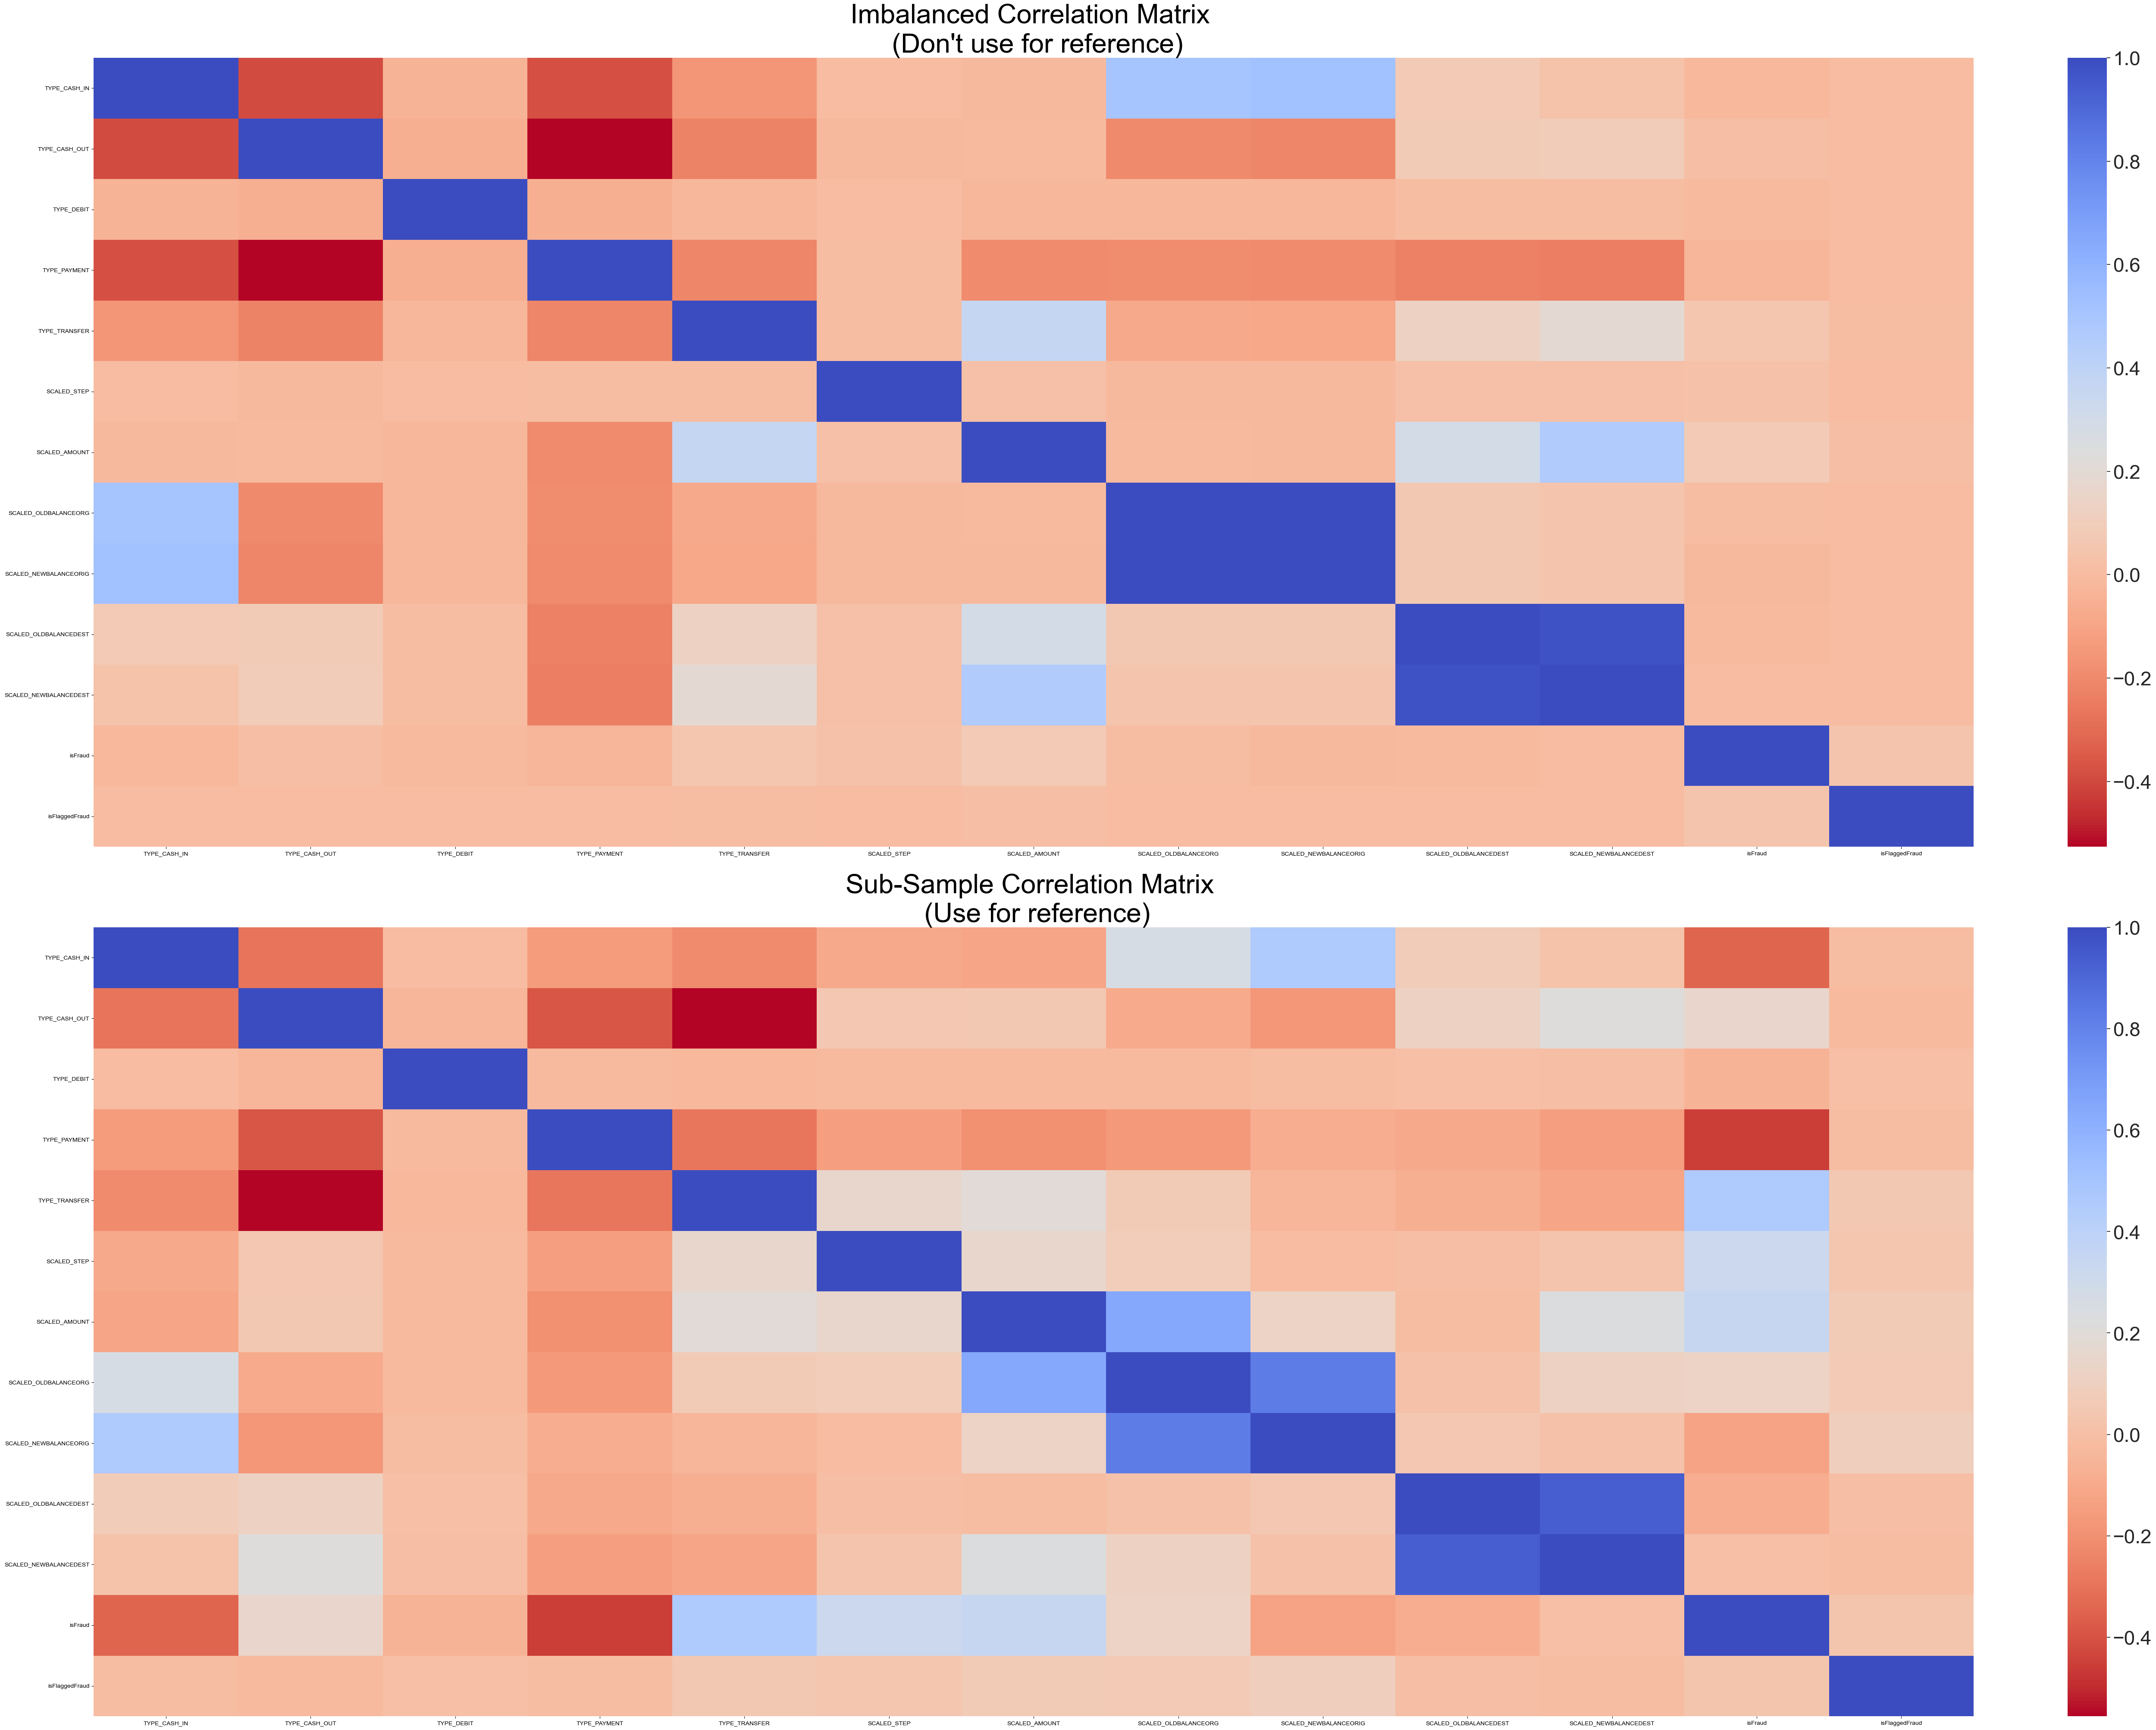

In [31]:
# Use correlation matrices to determine if any features have strong correlations

fig, ax = plt.subplots(2, 1, figsize=(50,40), constrained_layout = True, sharey=True)

corr = df.corr()
sns.set(font_scale=3)
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':10}, ax=ax[0]);
ax[0].set_title("Imbalanced Correlation Matrix \n (Don't use for reference)", fontsize=45);

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':10}, ax=ax[1]);
ax[1].set_title('Sub-Sample Correlation Matrix \n (Use for reference)', fontsize=45);

plt.subplots_adjust(top=0, bottom=1, hspace=1.25, wspace=1.25)

In [32]:
sub_sample_corr['isFraud'].sort_values()

TYPE_PAYMENT            -0.453114
TYPE_CASH_IN            -0.344099
SCALED_NEWBALANCEORIG   -0.129716
SCALED_OLDBALANCEDEST   -0.083420
TYPE_DEBIT              -0.058488
SCALED_NEWBALANCEDEST    0.000446
isFlaggedFraud           0.031225
SCALED_OLDBALANCEORG     0.124529
TYPE_CASH_OUT            0.148021
SCALED_STEP              0.322947
SCALED_AMOUNT            0.349331
TYPE_TRANSFER            0.453688
isFraud                  1.000000
Name: isFraud, dtype: float64

It appears as though there are several features with mild correlations with the target variable. We will examine these correlations further and determine if any additional data processing steps need to be taken. *Note that we will only look at the non-binary correlated features, because only the non-binary features can be processed additionally. 

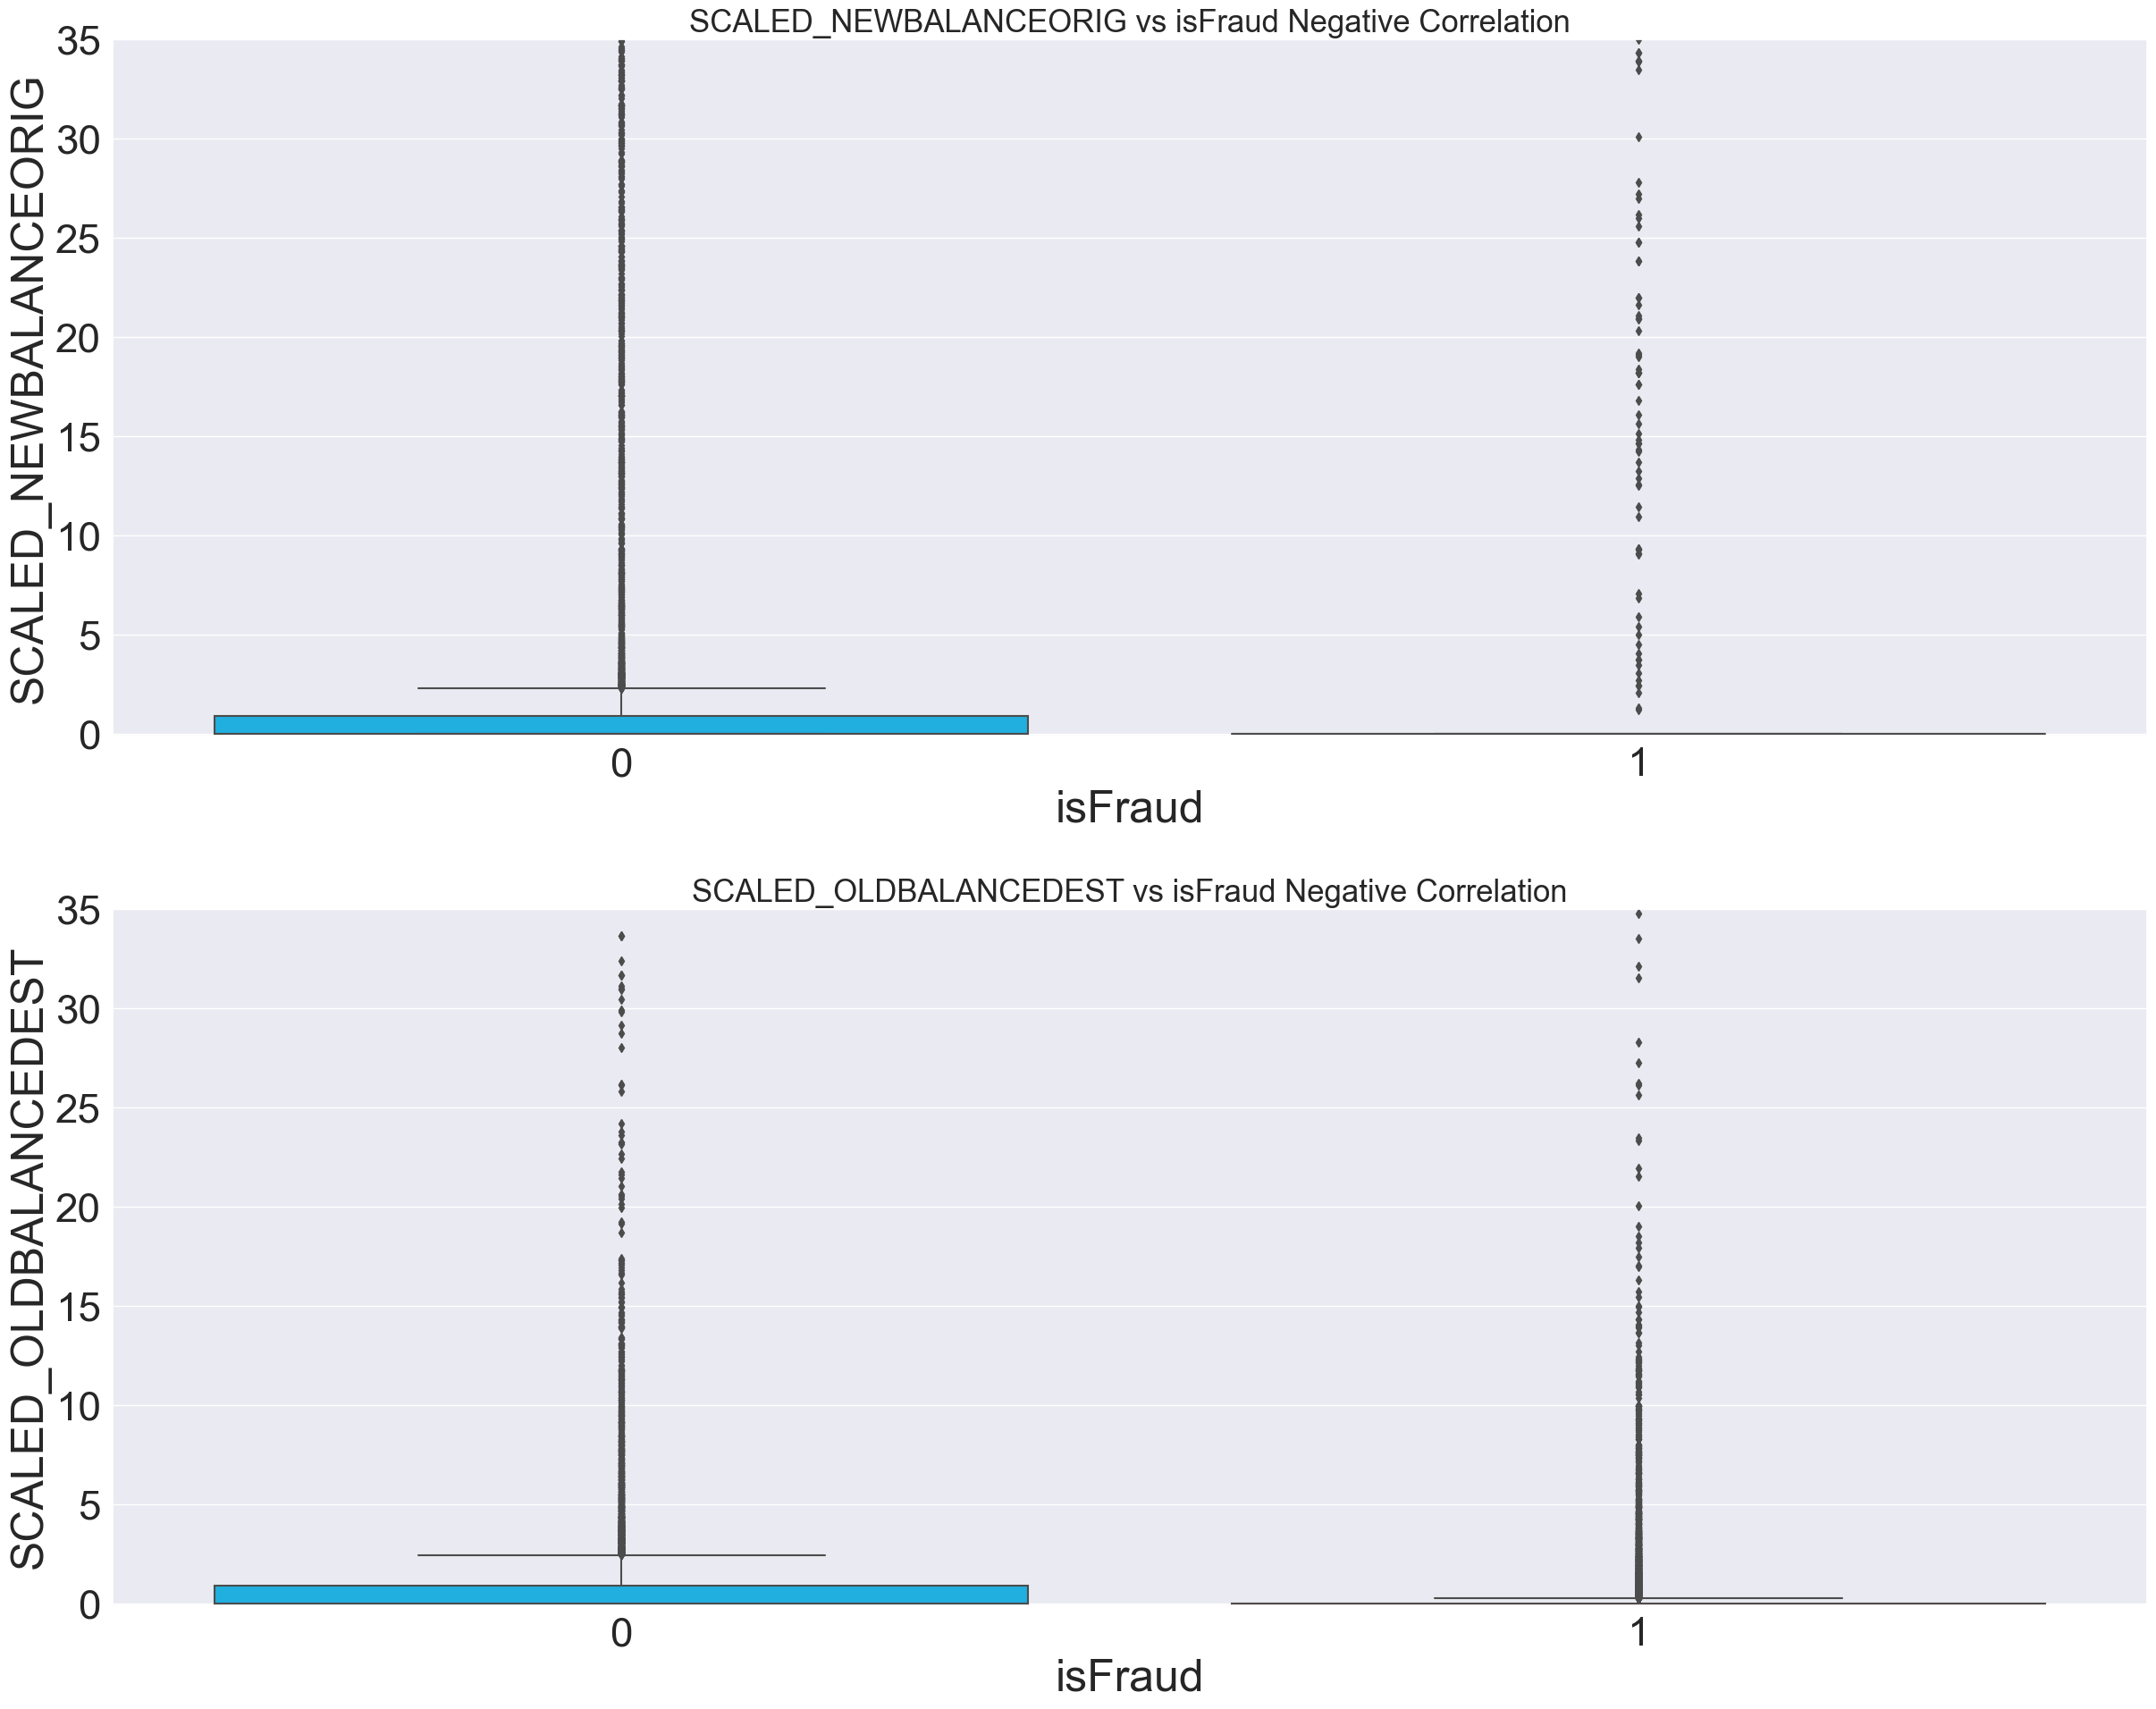

In [33]:
# Non-binary negatively correlated features

negative_features = ['SCALED_NEWBALANCEORIG', 'SCALED_OLDBALANCEDEST']

colors = ['deepskyblue', 'red']

# Negative correlations with isFraud
# The lower the feature value the more likely it will be a fraudulent transaction

fig, ax = plt.subplots(2, 1, figsize=(25,20), sharey=True)

sns.boxplot(x='isFraud', y=negative_features[0], data=new_df, palette=colors, ax=ax[0])
ax[0].set_title(f'{negative_features[0]} vs isFraud Negative Correlation', fontsize=25)

        
sns.boxplot(x='isFraud', y=negative_features[1], data=new_df, palette=colors, ax=ax[1])
ax[1].set_title(f'{negative_features[1]} vs isFraud Negative Correlation', fontsize=25)
ax[0].set_ylim([-.1,35])

      
plt.tight_layout()
plt.show()

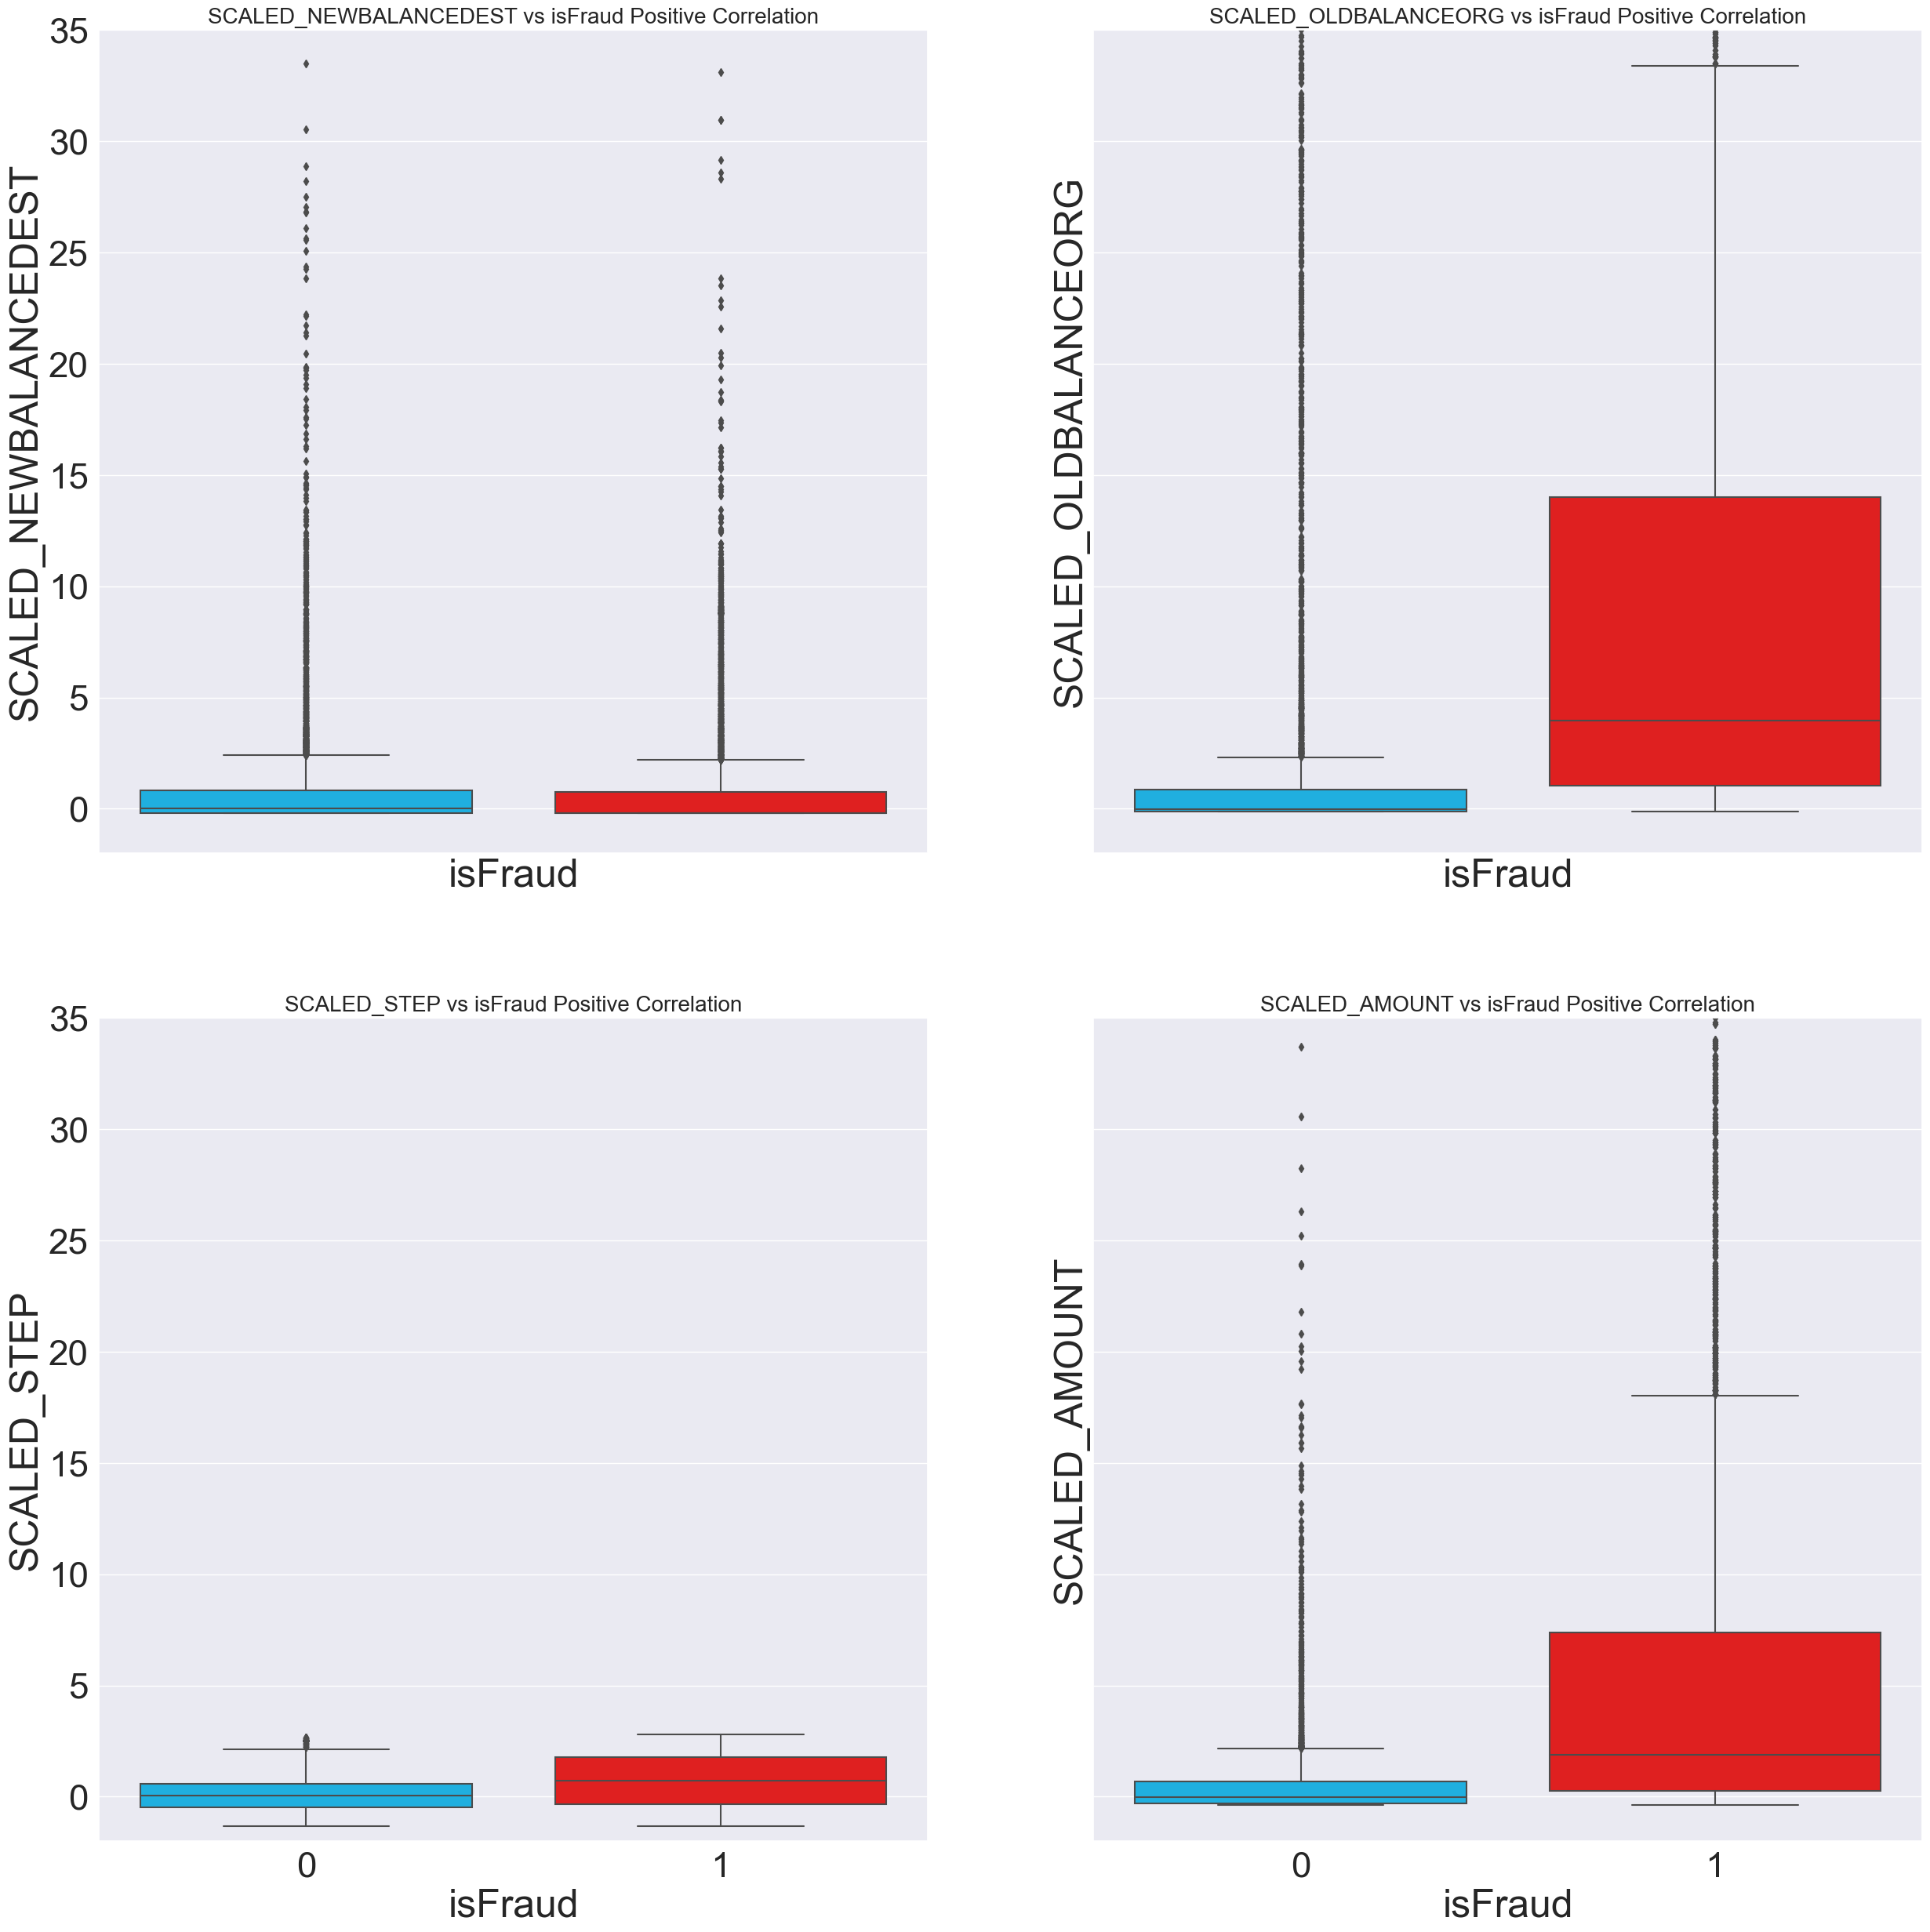

In [34]:
# Non-binary positively correlated features 

positive_features = ['SCALED_NEWBALANCEDEST', 'SCALED_OLDBALANCEORG', 'SCALED_STEP', 'SCALED_AMOUNT']

# Positive correlations with isFraud
# The greater the feature value the more likely it will be a fraudulent transaction

fig, ax = plt.subplots(2, 2, figsize=(30,30), sharex=True, sharey=True)

for i in range(2):
    for j in range(2):
        index = 2*i+j
        sns.boxplot(x='isFraud', y=positive_features[index], data=new_df, palette=colors, ax=ax[i,j])
        ax[i,j].set_title(f'{positive_features[index]} vs isFraud Positive Correlation', fontsize=20)


ax[0,0].set_ylim([-2, 35]);

From these boxplots, we can see that some of the features have many extreme outliers. In the next section we will remove some of the outliers from the most skewed features.

# Anomaly Detection

In this section we will remove extreme outliers from the features with a strong correlation with 'isFraud'. To do so we will use the InterQuartile Range (IQR) to determine a threshold in which outliers will be deleted. We will need to experiment with different thresholds for the IQR to find a balance between removing enough outliers to achieve a more accurate model and removing too many outliers and risking data loss. 

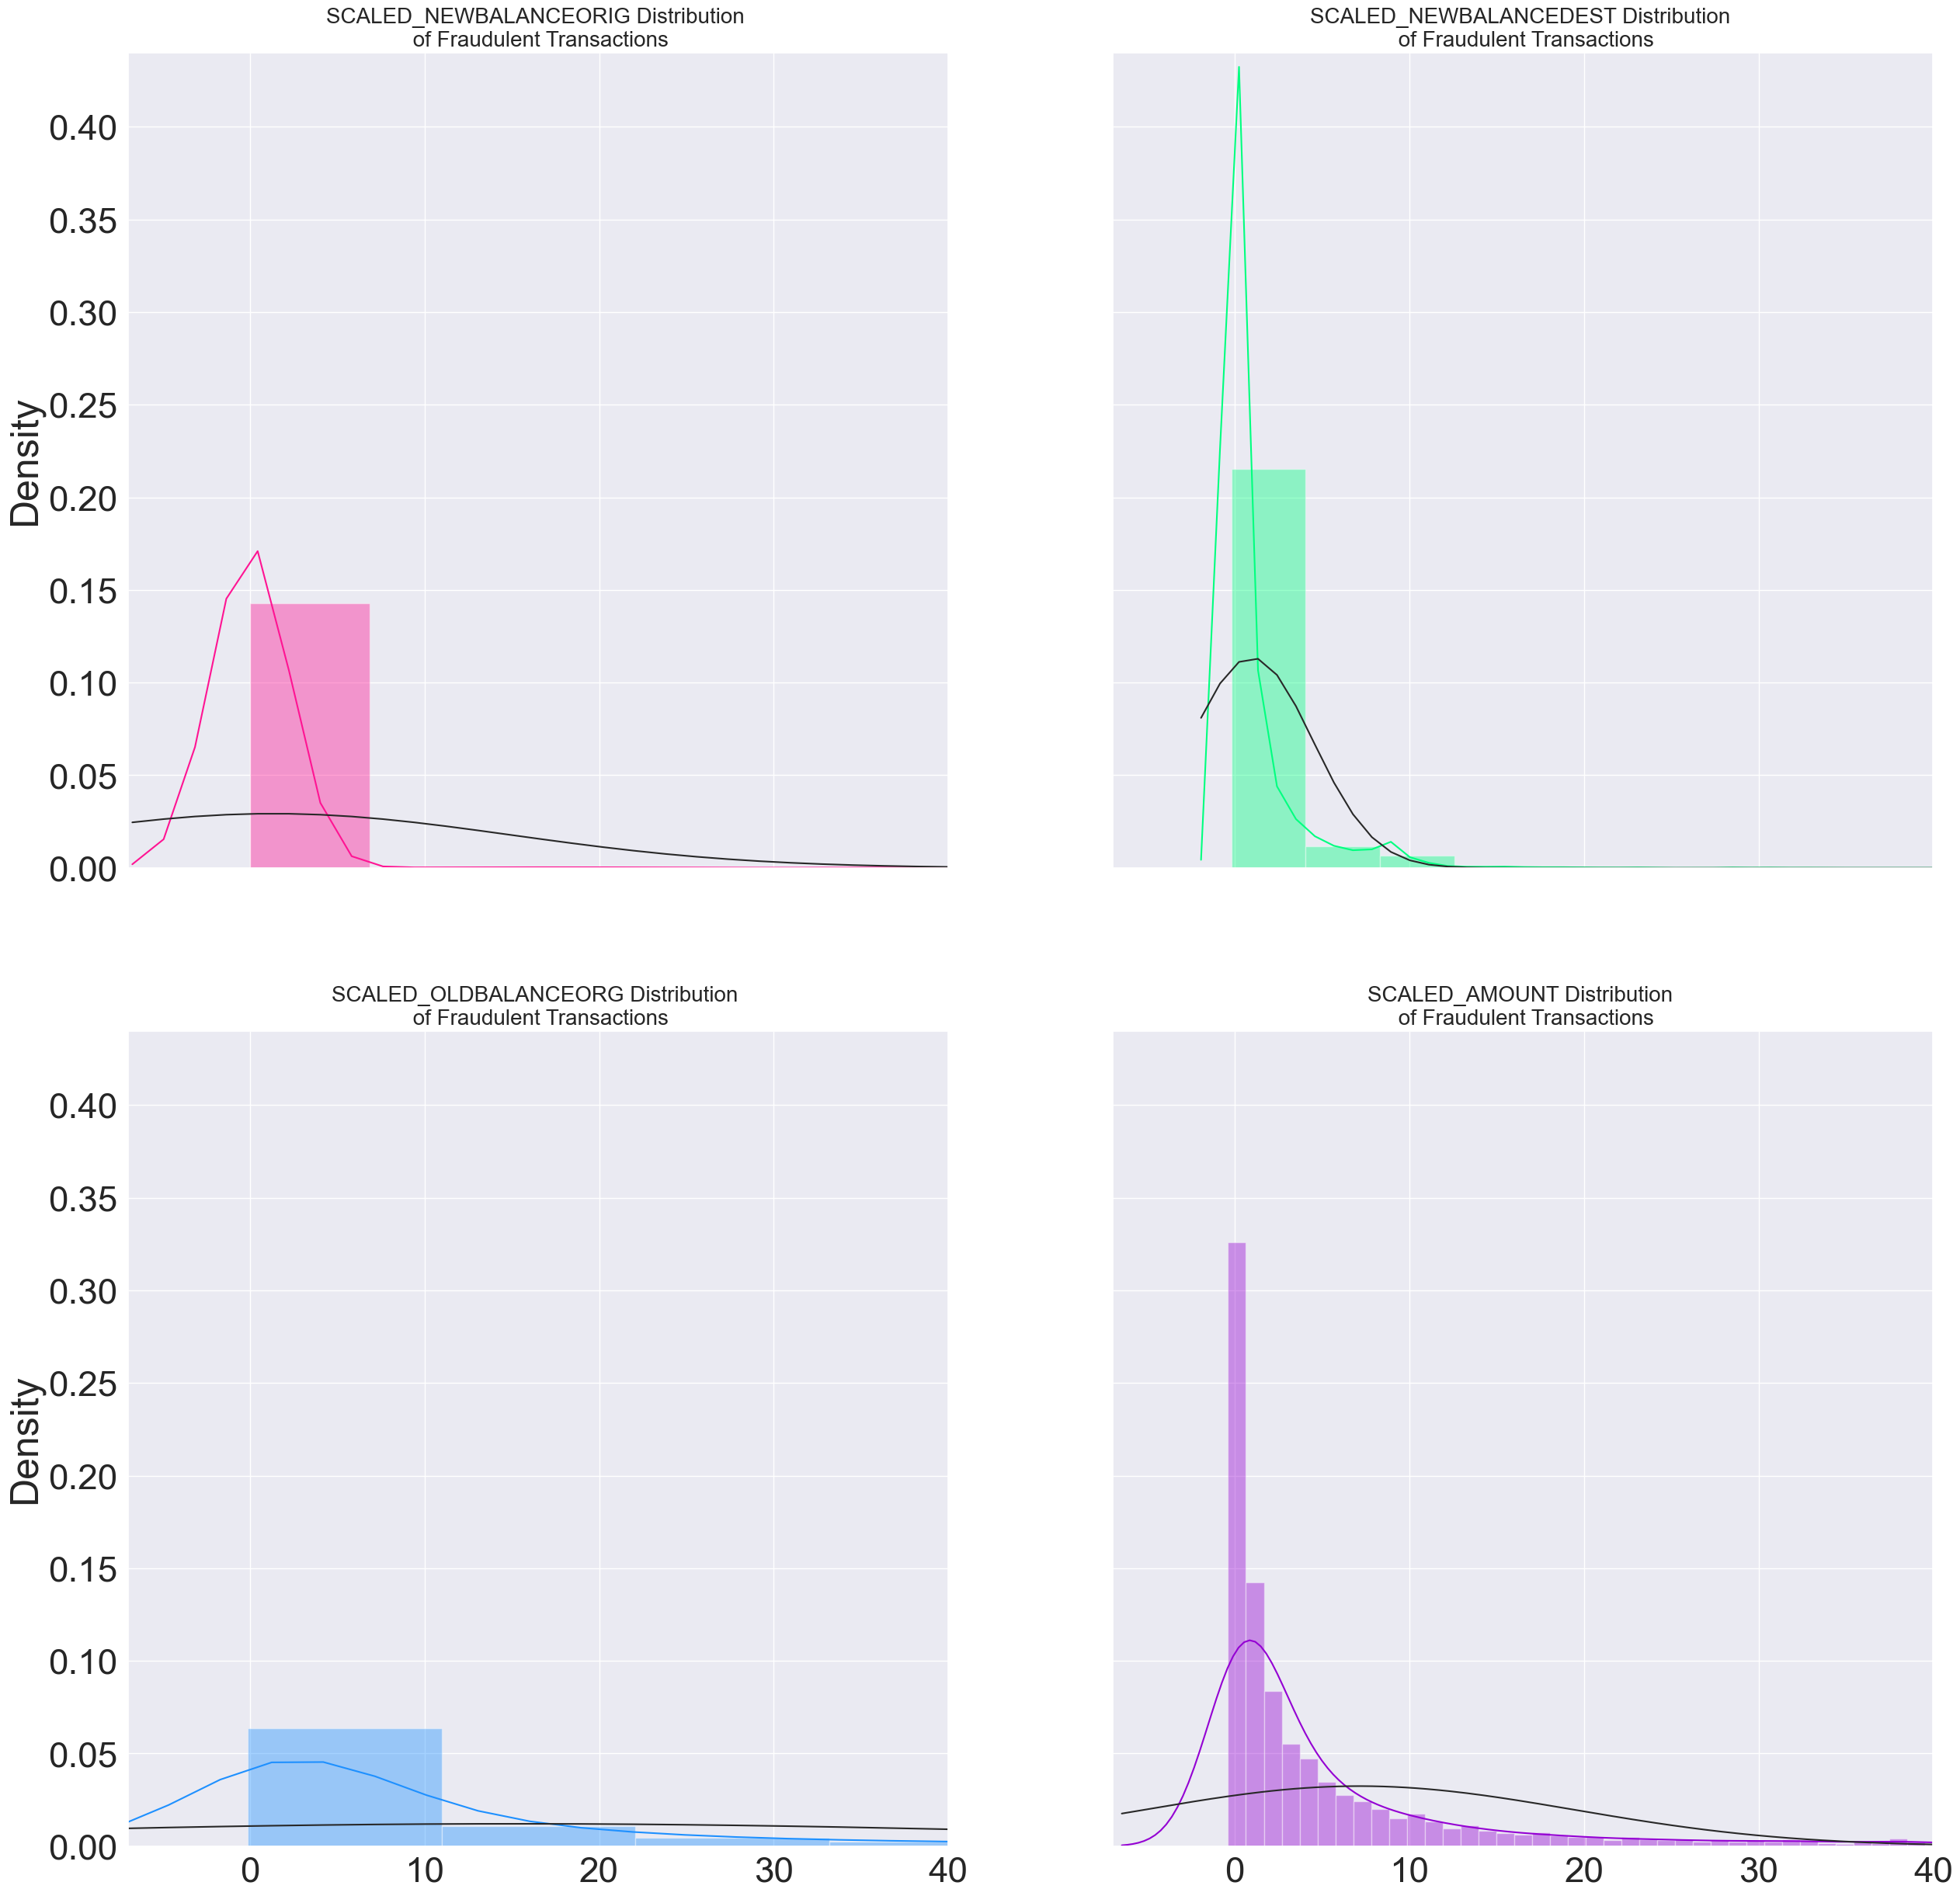

In [35]:
# Visualizing distributions of non-binary features with many outliers

outliers =['SCALED_NEWBALANCEORIG', 'SCALED_NEWBALANCEDEST', 'SCALED_OLDBALANCEORG', 'SCALED_AMOUNT']

colors = ['deeppink', 'springgreen', 'dodgerblue', 'darkviolet']

fig, ax = plt.subplots(2, 2, figsize=(30,30), sharex=True, sharey=True)

for i in range(2):
    for j in range(2):
        index = 2*i+j

        fraud_dist = new_df[outliers[index]].loc[new_df['isFraud'] == 1].values
        sns.distplot(fraud_dist, fit=norm, ax=ax[i,j], color=colors[index])
        ax[i,j].set_title(f'{outliers[index]} Distribution \n of Fraudulent Transactions', fontsize=20)

ax[0,0].set_ylim([0,0.44])
ax[0,0].set_xlim([-7,40])

plt.show()

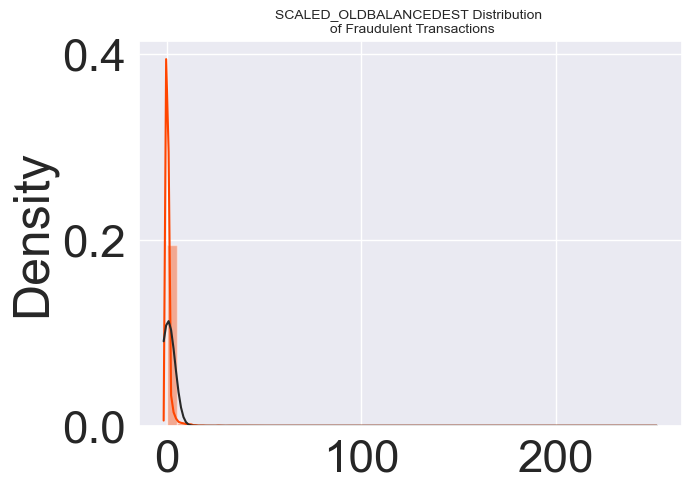

In [36]:
fraud_dist = new_df['SCALED_OLDBALANCEDEST'].loc[new_df['isFraud'] == 1].values
plt.figure(figsize=(7,5))
sns.distplot(fraud_dist, fit=norm, color='orangered')
plt.title('SCALED_OLDBALANCEDEST Distribution \n of Fraudulent Transactions', fontsize=10);

'SCALED_OLDBALANCEDEST' is one of the features with the most skewed distributions. Post-hoc, I know that using the IQR to drop outliers doesn't have an effect on the feature because the feature is almost entirely distributed at zero with a handful of extreme outliers. Removing any outliers from this feature results in the feature only taking on zero as a value. Therefore this feature provides no additional information to our model and it is best to remove it from the dataset.  

In [37]:
new_df = new_df.drop('SCALED_OLDBALANCEDEST', axis=1)
true_Xtest = true_Xtest.drop('SCALED_OLDBALANCEDEST', axis=1)
X_train = X_train.drop('SCALED_OLDBALANCEDEST', axis=1)

## Dropping Outliers

From the distributions above, we can see that two of the four features, 'SCALED_OLDBALANCEORG', and ‘SCALED_AMOUNT', have the most skewed distributions. In this section, outliers will be removed from these two features. 

There is no one-size-fits-all approach to this step. Through trial and error, I determined the appropriate ranges for each feature. For 'SCALED_OLDBALANCEORG', I am using the 15th and 85th percentile range to drop outliers because the IQR was dropping too many observations and we risked data loss. 'SCALED_AMOUNT' is considerably more skewed than 'SCALED_OLDBALANCEORG', so the IQR was an appropriate range to use. A graph is shown to depict the difference before dropping the outliers and after. 

In [38]:
# Removing Outliers from SCALED_OLDBALANCEORG 

oldbalanceorg_fraud = new_df['SCALED_OLDBALANCEORG'].loc[new_df['isFraud'] == 1].values
q15, q85 = np.percentile(oldbalanceorg_fraud, 15), np.percentile(oldbalanceorg_fraud, 85)
print(f'Percentile 15: {q15} | Percentile 85: {q85}')
oldbalanceorg_range = q85 - q15
print(f'Range: {oldbalanceorg_range}')

oldbalanceorg_cut_off = oldbalanceorg_range * 2.5
oldbalanceorg_lower, oldbalanceorg_upper = q15 - oldbalanceorg_range, q85 + oldbalanceorg_range
print(f'Cut Off: {oldbalanceorg_cut_off}')
print(f'SCALED_OLDBALANCEORG Lower: {oldbalanceorg_lower}')
print(f'SCALED_OLDBALANCEORG Upper: {oldbalanceorg_upper}')

outliers = [x for x in oldbalanceorg_fraud if x < oldbalanceorg_lower or x > oldbalanceorg_upper]
print(f'Feature SCALED_OLDBALANCEORG Outliers for Fraud Cases: {len(outliers)}')
print(f'SCALED_OLDBALANCEORG outliers:{outliers}')

oldbalanceorg_old_fraud_dist = new_df['SCALED_OLDBALANCEORG'].loc[new_df['isFraud'] == 1].values
new_df = new_df.drop(new_df[(new_df['SCALED_OLDBALANCEORG'] > oldbalanceorg_upper) | (new_df['SCALED_OLDBALANCEORG'] < oldbalanceorg_lower)].index)

Percentile 15: 0.4404038850982631 | Percentile 85: 26.64624096265975
Range: 26.205837077561487
Cut Off: 65.51459269390372
SCALED_OLDBALANCEORG Lower: -25.765433192463224
SCALED_OLDBALANCEORG Upper: 52.85207804022124
Feature SCALED_OLDBALANCEORG Outliers for Fraud Cases: 654
SCALED_OLDBALANCEORG outliers:[189.5320603074076, 93.05107129536898, 102.2537920662199, 93.05107129536898, 182.44978522375794, 72.38719193254822, 93.05107129536898, 254.40993829623815, 93.05107129536898, 59.67078831115916, 67.1332922860164, 176.73778084040768, 84.30072615545751, 66.9367055497976, 71.58939404422533, 164.589142122724, 121.18968049020094, 164.52314483948797, 93.05107129536898, 83.09489026132603, 54.87806724445075, 418.188621413514, 58.78191942565438, 271.13291703619734, 93.05107129536898, 99.80001626051488, 93.05107129536898, 257.70661120386745, 93.05107129536898, 69.21478896157976, 66.16382137940883, 122.60034603680234, 84.04731884377023, 61.80553421265911, 210.6964323545109, 71.58939404422533, 93.051

In [39]:
# Removing Outliers from SCALED_AMOUNT 

amount_fraud = new_df['SCALED_AMOUNT'].loc[new_df['isFraud'] == 1].values
q25, q75 = np.percentile(amount_fraud, 25), np.percentile(amount_fraud, 75)
print(f'Percentile 25: {q25} | Percentile 75: {q75}')
amount_range = q75 - q25
print(f'Range: {amount_range}')

amount_cut_off = amount_range * 2
amount_lower, amount_upper = q25 - amount_range, q75 + amount_range
print(f'Cut Off: {amount_cut_off}')
print(f'SCALED_AMOUNT Lower: {amount_lower}')
print(f'SCALED_AMOUNT Upper: {amount_upper}')

outliers = [x for x in amount_fraud if x < amount_lower or x > amount_upper]
print(f'Feature SCALED_AMOUNT Outliers for Fraud Cases: {len(outliers)}')
print(f'SCALED_AMOUNT outliers:{outliers}')

amount_old_fraud_dist = new_df['SCALED_AMOUNT'].loc[new_df['isFraud'] == 1].values
new_df = new_df.drop(new_df[(new_df['SCALED_AMOUNT'] > amount_upper) | (new_df['SCALED_AMOUNT'] < amount_lower)].index)

Percentile 25: 0.20118433543685124 | Percentile 75: 5.258386037109682
Range: 5.057201701672831
Cut Off: 10.114403403345662
SCALED_AMOUNT Lower: -4.85601736623598
SCALED_AMOUNT Upper: 10.315587738782513
Feature SCALED_AMOUNT Outliers for Fraud Cases: 961
SCALED_AMOUNT outliers:[13.358742887410752, 10.612226218084723, 11.502276605781878, 25.183120325592476, 20.078269956996145, 12.301062641289162, 10.462583385154318, 17.031365241748844, 15.389710203899996, 17.494248705885393, 10.623480702967077, 18.756295409647805, 19.95627355453947, 20.875053247508987, 12.918545373852963, 14.707847615730676, 13.406149069629087, 21.34109221249478, 19.95627355453947, 16.678668947109934, 11.493534767226905, 18.535415367302445, 10.60278833349334, 17.891846369236937, 11.70363730769383, 18.827690299394636, 24.268002143991755, 24.401852114202075, 13.219044103176026, 10.35039546726384, 25.440163123375015, 11.541933362832694, 17.902532334611028, 15.593044060146703, 10.552437010323057, 10.488498966816264, 15.19075

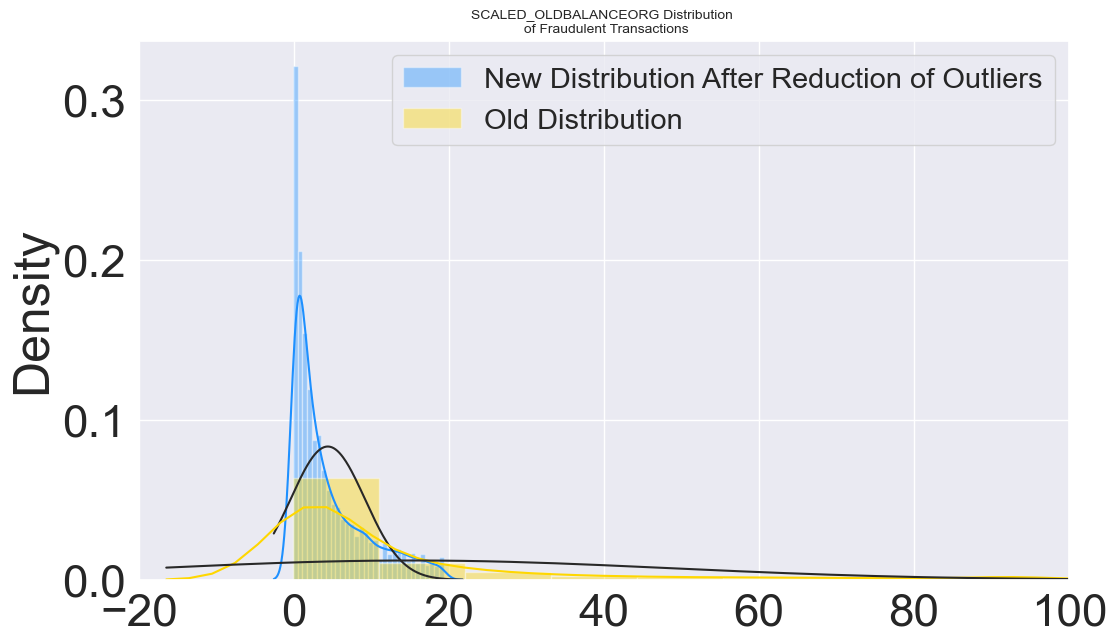

In [40]:
fraud_dist = new_df['SCALED_OLDBALANCEORG'].loc[new_df['isFraud'] == 1].values
plt.figure(figsize=(12,7))
sns.distplot(fraud_dist, fit=norm, color='dodgerblue', label='New Distribution After Reduction of Outliers')
sns.distplot(oldbalanceorg_old_fraud_dist, fit=norm, color='gold', label='Old Distribution')
plt.xlim([-20, 100])
plt.title('SCALED_OLDBALANCEORG Distribution \n of Fraudulent Transactions', fontsize=10);
plt.legend(loc='upper right', fontsize='xx-small');

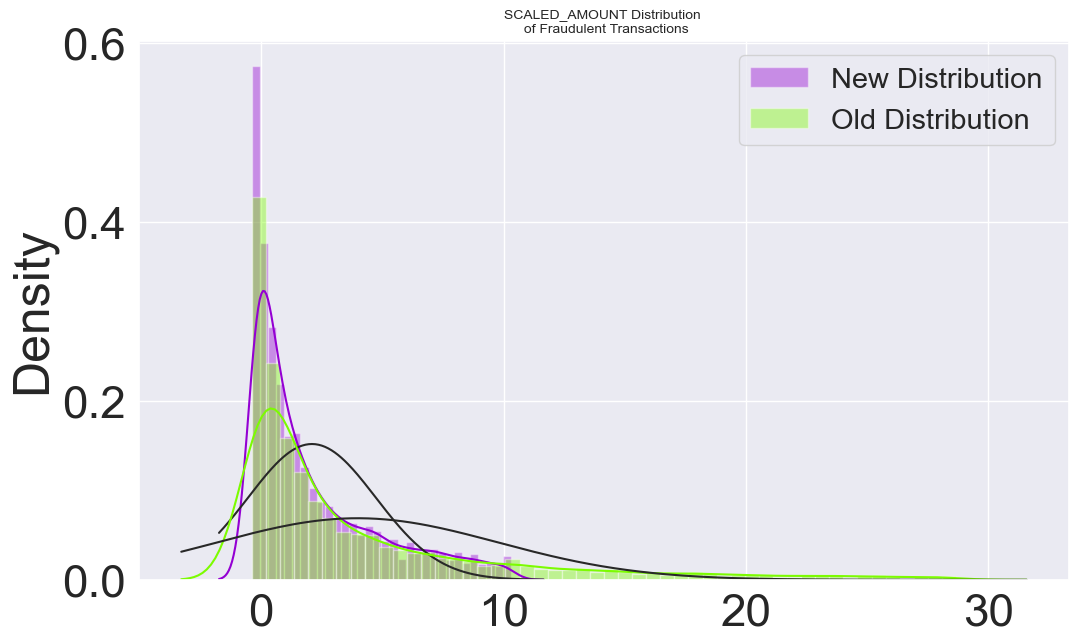

In [41]:
fraud_dist = new_df['SCALED_AMOUNT'].loc[new_df['isFraud'] == 1].values
plt.figure(figsize=(12,7))
sns.distplot(fraud_dist, fit=norm, color='darkviolet', label='New Distribution')
sns.distplot(amount_old_fraud_dist, fit=norm, color='lawngreen', label='Old Distribution')
plt.title('SCALED_AMOUNT Distribution \n of Fraudulent Transactions', fontsize=10);
plt.legend(loc='upper right', fontsize='xx-small');

# Dimensionality Reduction and Clustering

When working with data, it can be helpful to make visualizations to assist in our understanding. This dataset has a dimension of 12. A graph in 12 dimensions is physically impossible for the human brain to comprehend, so we use dimensionality reduction to cast the dataset to a lower dimension to graphically visualize fraud and non-fraud.

In [42]:
X = new_df.drop('isFraud', axis=1)
y = new_df['isFraud']

In [43]:
# PCA Implementation
# Reduce to a two-dimensional space
t0 = time.time()
X_reduced_pca = PCA(n_components=2).fit_transform(X.values)
t1 = time.time()
print('PCA took {:.2} s'.format(t1 - t0))

# TruncatedSVD
# Reduce to a two-dimensional space
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized').fit_transform(X.values)
t1 = time.time()
print('Truncated SVD took {:.2} s'.format(t1 - t0))

PCA took 0.031 s
Truncated SVD took 0.021 s


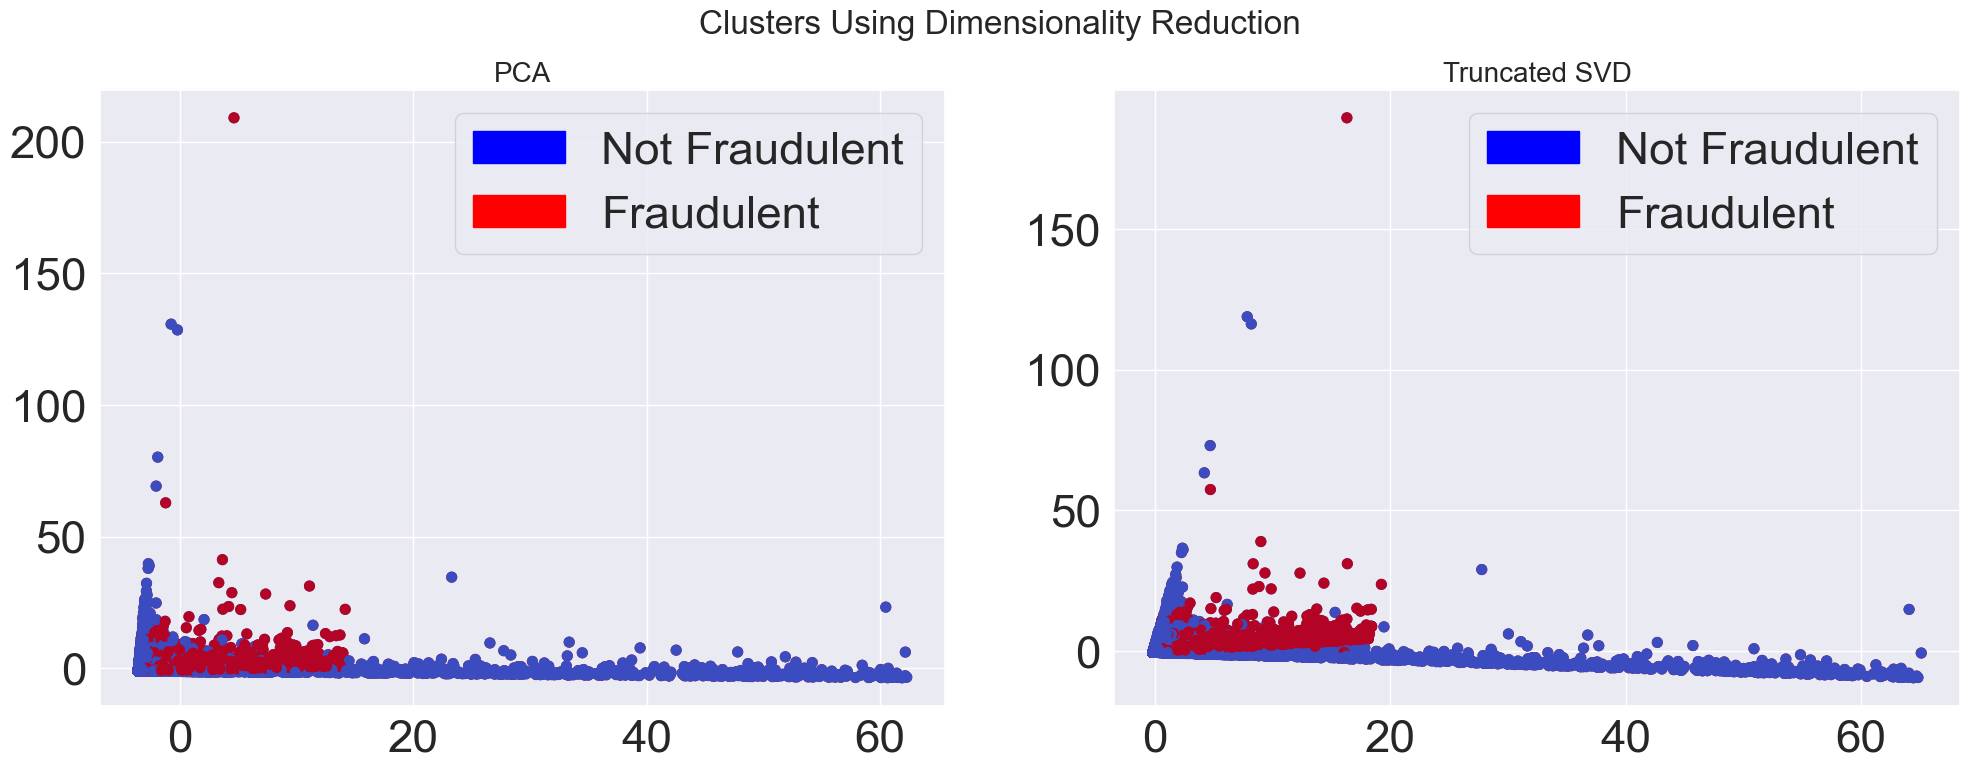

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(24,8))

labels = ['Not Fraudulent', 'Fraudulent']
fig.suptitle('Clusters Using Dimensionality Reduction', fontsize=24)

blue_patch = mpatches.Patch(color='blue', label='Not Fraudulent')
red_patch = mpatches.Patch(color='red', label='Fraudulent')


# PCA scatter plot
axes[0].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label=labels[0], linewidths=2)
axes[0].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label=labels[1], linewidths=2)
axes[0].set_title('PCA', fontsize=20)

axes[0].grid(True)
axes[0].legend(handles=[blue_patch, red_patch])


# TruncatedSVD scatter plot
axes[1].scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label=labels[0], linewidths=2)
axes[1].scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label=labels[1], linewidths=2)
axes[1].set_title('Truncated SVD', fontsize=20)

axes[1].grid(True)
axes[1].legend(handles=[blue_patch, red_patch])

plt.show()

# Training Classifiers

In this section we will train four different classifiers and compare the results to see which classifier fits the data the best. 

To hypertune the parameters for each classifier, I used the cross validation score of each classifier and the GridSearchCV method from Scikit-Learn to run through all the possible parameters and determine which had the best performance. The time it took to determine the best performing parameters was over 4 hours each time. Therefore I made the decision to run the code once, determine which parameters performed the best, and initialize each classifier with said parameters. This significantly cut down on training time, and is also why the proceeding code blocks have many lines of code commented out. 

In [45]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import KFold, StratifiedKFold

In [46]:
def cross_validation_score(classifier, params):

    t0 = time.time()

    X = df.drop('isFraud', axis=1)
    y = df['isFraud']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    under = RandomUnderSampler(sampling_strategy=.5)

    pipeline = imbpipeline(steps = [['undersample', under],
                                    ['classifier', classifier]])

    
    stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=params,
                               scoring='roc_auc',
                               cv=stratified_kfold)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_estimator_
    cross_val_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    t1 = time.time()

    print('Training time {:.4} s'.format(t1 - t0))
    
    return [best_params, cross_val_score, test_score]

In [47]:
# parameters = {
#     'Logisitic Regression': {'classifier__penalty': ['l2'], 
#                              'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    
#     'KNearest': {'classifier__n_neighbors': list(range(2,5,1)), 
#                  'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree']},
    
#     'Support Vector Classifier': {'classifier__C': [0.5, 0.7, 0.9, 1], 
#                                   'classifier__kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
    
#     'Decision Tree Classifier': {'classifier__criterion': ['gini', 'entropy'], 
#                                  'classifier__max_depth': list(range(2,4,1)), 
#                                  'classifier__min_samples_leaf': list(range(5,7,1))}
# }

In [48]:
# log_reg = cross_validation_score(LogisticRegression(random_state=42, max_iter=1000), 
#                                  parameters['Logisitic Regression'])

# print('-' * 100)

# log_reg_classifier = log_reg[0]['classifier']
# log_reg_cross_val_score = log_reg[1]
# log_reg_score = log_reg[2]

# print('Logistic Regression Optimized Parameters :', log_reg_classifier,
#       '\nLogistic Regression Cross Validation Score :', log_reg_cross_val_score, 
#       '\nLogistic Regression Score :', log_reg_score)

log_reg_classifier = LogisticRegression(C=1000, max_iter=1000, random_state=42).fit(X_train, y_train)

In [49]:
# knears_neighbors = cross_validation_score(KNeighborsClassifier(), 
#                                           parameters['KNearest'])
# print('-' * 100)

# knears_neighbors_classifier = knears_neighbors[0]['classifier']
# knears_neighbors_cross_val_score = knears_neighbors[1]
# knears_neighbors_score = knears_neighbors[2]

# print('K Nearest Neighbors Optimized Parameters :', knears_neighbors_classifier,
#       '\nK Nearest Neighbors Cross Validation Score :', knears_neighbors_cross_val_score, 
#       '\nK Nearest Neighbors Score :', knears_neighbors_score)

knears_neighbors_classifier = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)

In [50]:
# svc = cross_validation_score(SVC(random_state=42, max_iter=1000), 
#                              parameters['Support Vector Classifier'])

# print('-' * 100)

# sv_classifier = svc[0]['classifier']
# svc_cross_val_score = svc[1]
# svc_score = svc[2]

# print('Support Vector Classifier Optimized Parameters :', sv_classifier,
#       '\nSupport Vector Classifier Cross Validation Score :', svc_cross_val_score, 
#       '\nSupport Vector Classifier Score :', svc_score)

sv_classifier = SVC(C=0.9, kernel='linear', max_iter=1000, random_state=42).fit(X_train, y_train)

In [51]:
# tree_clf = cross_validation_score(DecisionTreeClassifier(random_state=42), 
#                                   parameters['Decision Tree Classifier'])

# tree_classifier = tree_clf[0]['classifier']
# tree_clf_cross_val_score = tree_clf[1]
# tree_clf_score = tree_clf[2]

# print('Decision Tree Classifier Optimized Parameters :', tree_classifier,
#       '\nDecision Tree Classifier Cross Validation Score :', tree_clf_cross_val_score, 
#       '\nDecision Tree Classifier Score :', tree_clf_score)
  
tree_classifier = DecisionTreeClassifier(criterion='entropy', 
                                         max_depth=3, 
                                         min_samples_leaf=5, 
                                         random_state=42).fit(X_train, y_train)

# Testing Classifier Accuracy

Now that we have trained the models, it is time to test them on the unseen data we set aside ahead of time. First, we use the classifier to predict the outcome of the data. Then we compare the predictions to the true value of the data. The results are summarized in both a confusion matrix and in a classification report. 

In [52]:
# Always test models on the original dataset with only unseen data

y_pred_log_reg = log_reg_classifier.predict(true_Xtest)
y_pred_knear = knears_neighbors_classifier.predict(true_Xtest)
y_pred_svc = sv_classifier.predict(true_Xtest)
y_pred_tree = tree_classifier.predict(true_Xtest)

In [53]:
from sklearn.metrics import f1_score

log_reg_score = f1_score(true_ytest, y_pred_log_reg, average='binary')
knears_score = f1_score(true_ytest, y_pred_knear, average='binary')
svc_score = f1_score(true_ytest, y_pred_svc, average='binary')
tree_score = f1_score(true_ytest, y_pred_tree, average='binary')

print('Logistic Regression f1 score: ', log_reg_score)
print('KNears Neighbors f1 score: ', knears_score)
print('Support Vector Classifier f1 score: ', svc_score)
print('Decision Tree Classifier f1 score: ', tree_score)

Logistic Regression f1 score:  0.17798686115131948
KNears Neighbors f1 score:  0.25492104479094246
Support Vector Classifier f1 score:  0.011462430620380788
Decision Tree Classifier f1 score:  0.08276982022557439


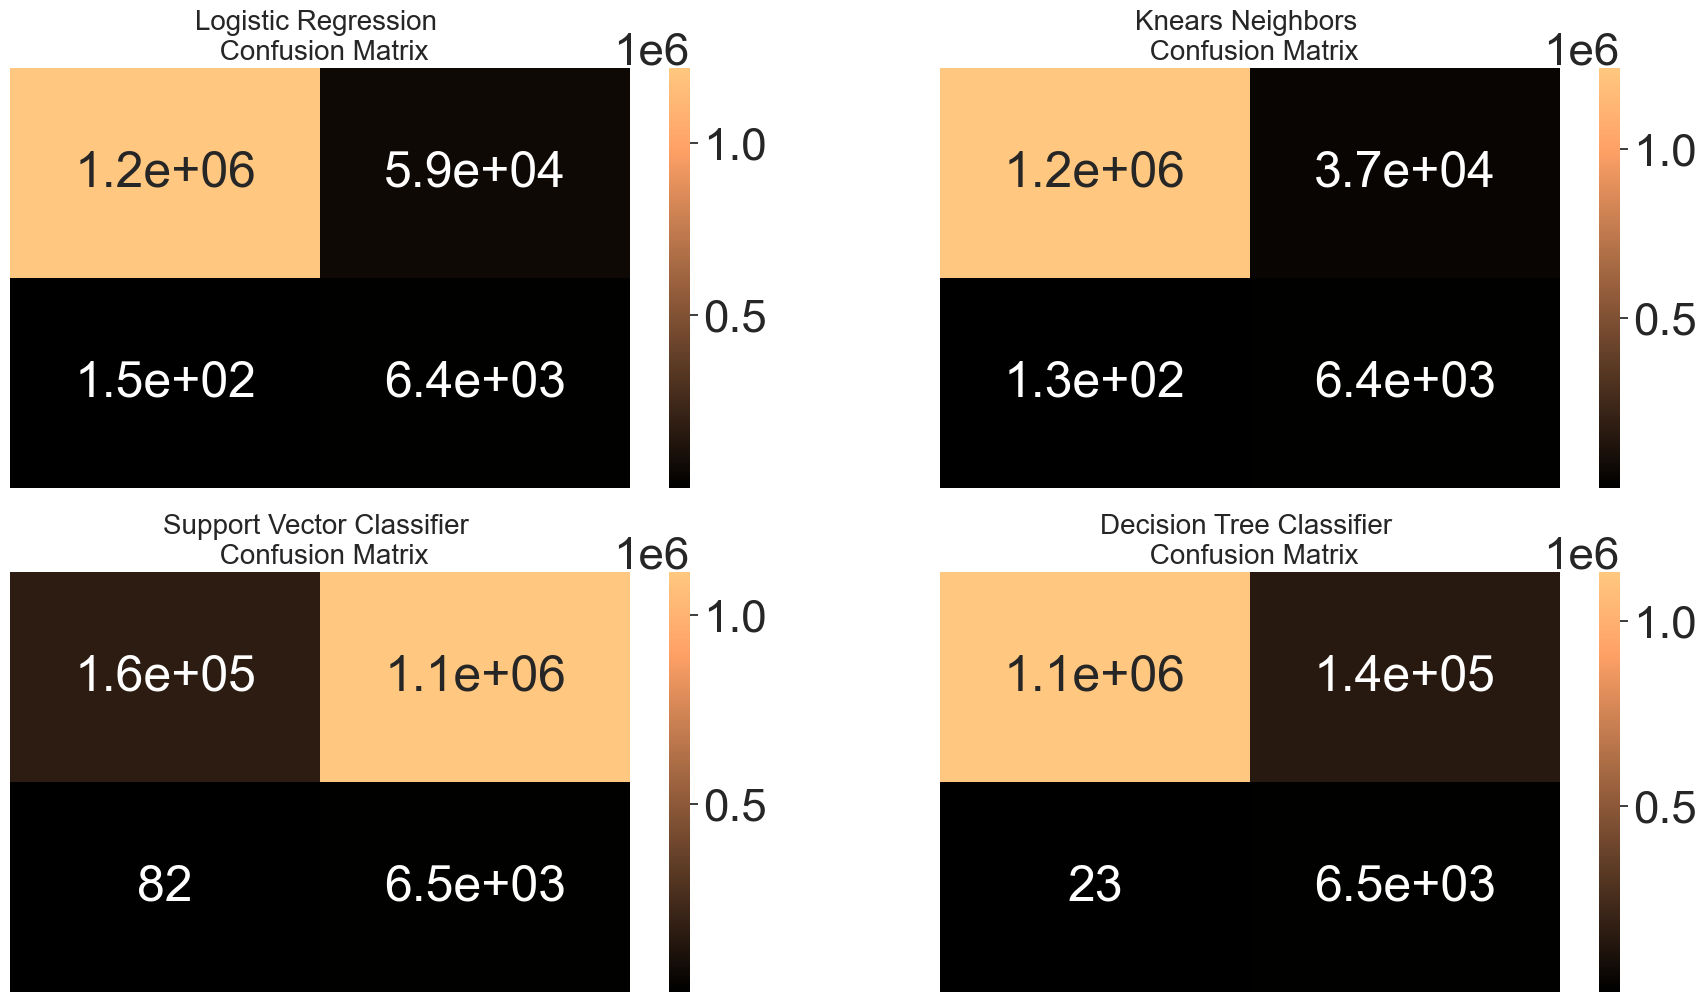

In [54]:
from sklearn.metrics import confusion_matrix

log_reg_cf = confusion_matrix(true_ytest, y_pred_log_reg)
kneighbors_cf = confusion_matrix(true_ytest, y_pred_knear)
svc_cf = confusion_matrix(true_ytest, y_pred_svc)
tree_cf = confusion_matrix(true_ytest, y_pred_tree)

maps = [log_reg_cf, kneighbors_cf, svc_cf, tree_cf]
titles = ['Logistic Regression', 'Knears Neighbors', 'Support Vector Classifier', 'Decision Tree Classifier']

fig, axes = plt.subplots(2, 2,figsize=(22,12))

for i in range(2):
    for j in range(2):
        index = 2*i+j
        sns.heatmap(maps[index], ax=axes[i,j], annot=True, cmap=plt.cm.copper)
        axes[i,j].set_title(f'{titles[index]} \n Confusion Matrix', fontsize=20)
        axes[i,j].set_xticklabels(['', ''], fontsize=14, rotation=90)
        axes[i,j].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [55]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(true_ytest, y_pred_log_reg))
print('-' * 100)

print('KNears Neighbors:')
print(classification_report(true_ytest, y_pred_knear))
print('-' * 100)

print('Support Vector Classifier:')
print(classification_report(true_ytest, y_pred_svc))
print('-' * 100)

print('Support Vector Classifier:')
print(classification_report(true_ytest, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1275782
           1       0.10      0.98      0.18      6547

    accuracy                           0.95   1282329
   macro avg       0.55      0.97      0.58   1282329
weighted avg       1.00      0.95      0.97   1282329

----------------------------------------------------------------------------------------------------
KNears Neighbors:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99   1275782
           1       0.15      0.98      0.25      6547

    accuracy                           0.97   1282329
   macro avg       0.57      0.98      0.62   1282329
weighted avg       1.00      0.97      0.98   1282329

----------------------------------------------------------------------------------------------------
Support Vector Classifier:
              precision    recall  f1-score   support

           0       1.00

# Final Words

The overall performance of the models are not to my satisfaction. An average model may have an accuracy rate of approximately 70%, whereas these models have an accuracy rate of at most 25%. The cross validation scores of each model were determined to be in the range of 97-99%, which implies that the models are not generalizing from the sub-sample to the entire sample very well. I suspect that toying with the ratio of fraud to non-fraud examples in the sub-sample could improve the performance of the models, but that is a hypothesis to investigate at another time. 

Throughout this project, I encountered many challenges, delays, frustrations, and setbacks. Although I am not completely satisfied with this end result, I am still proud of myself for sticking with this project through all the ups and downs, twists and turns. I can confidently say that I have significantly increased my knowledge in imbalance datasets, cross validation, and undersampling techniques through this project, which was ultimately my goal. 